In [16]:
import pandas as pd
import os

data_dir = './Dataset/Equities'

stock_data = {}
for file in os.listdir(data_dir):
    if file.endswith('.csv'):
        stock_name = file.split('.')[0]
        file_path = os.path.join(data_dir, file)
        stock_data[stock_name] = pd.read_csv(file_path)

for stock, data in stock_data.items():
    print(f"{stock} Data:")
    print(data.head())

BA Data:
         Date        Open        High         Low       Close   Adj Close  \
0  2014-05-27  133.089996  134.210007  132.869995  134.169998  115.965096   
1  2014-05-28  134.169998  135.149994  134.169998  134.330002  116.103371   
2  2014-05-29  134.710007  135.199997  134.429993  135.139999  116.803482   
3  2014-05-30  134.669998  135.440002  134.039993  135.250000  116.898544   
4  2014-06-02  135.500000  136.029999  134.770004  135.899994  117.460373   

    Volume  
0  3085500  
1  2609400  
2  2234100  
3  2760300  
4  2629900  
MSBHF Data:
         Date      Open      High       Low     Close  Adj Close  Volume
0  2014-05-27  6.466667  6.466667  6.466667  6.466667   4.680295       0
1  2014-05-28  6.466667  6.466667  6.466667  6.466667   4.680295       0
2  2014-05-29  6.466667  6.466667  6.466667  6.466667   4.680295       0
3  2014-05-30  6.466667  6.466667  6.466667  6.466667   4.680295       0
4  2014-06-02  6.466667  6.466667  6.466667  6.466667   4.680295       0


In [17]:
from sklearn.preprocessing import MinMaxScaler

def preprocess_data(df):
    df = df.dropna()

    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    scaler = MinMaxScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    return scaled_df, scaler

preprocessed_data = {}
scalers = {}
for stock, data in stock_data.items():
    preprocessed_data[stock], scalers[stock] = preprocess_data(data)

for stock, data in preprocessed_data.items():
    print(f"{stock} Preprocessed Data:")
    print(data.head())

BA Preprocessed Data:
                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2014-05-27  0.098888  0.089476  0.124918  0.113307   0.062498  0.022423
2014-05-28  0.101998  0.092221  0.128620  0.113770   0.062911  0.017774
2014-05-29  0.103554  0.092367  0.129360  0.116114   0.064999  0.014110
2014-05-30  0.103438  0.093067  0.128250  0.116432   0.065282  0.019247
2014-06-02  0.105828  0.094790  0.130328  0.118313   0.066958  0.017974
MSBHF Preprocessed Data:
                Open      High       Low     Close  Adj Close  Volume
Date                                                                 
2014-05-27  0.090584  0.089442  0.093794  0.093695   0.056429     0.0
2014-05-28  0.090584  0.089442  0.093794  0.093695   0.056429     0.0
2014-05-29  0.090584  0.089442  0.093794  0.093695   0.056429     0.0
2014-05-30  0.090584  0.089442  0.093794  0.093695   0.056429     0.0
2014-06-02  0.090584  0.08944

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_sequences(data, seq_length=60):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data.iloc[i:i+seq_length].values)
        labels.append(data['Close'].iloc[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 60
X, y = {}, {}
for stock, data in preprocessed_data.items():
    X[stock], y[stock] = create_sequences(data)

X_train, X_test, y_train, y_test = {}, {}, {}, {}
for stock in X:
    X_train[stock], X_test[stock], y_train[stock], y_test[stock] = train_test_split(X[stock], y[stock], test_size=0.2, random_state=42)

def to_tensor(data):
    return torch.tensor(data, dtype=torch.float32)

X_train_tensors = {stock: to_tensor(X_train[stock]) for stock in X_train}
X_test_tensors = {stock: to_tensor(X_test[stock]) for stock in X_test}
y_train_tensors = {stock: to_tensor(y_train[stock]) for stock in y_train}
y_test_tensors = {stock: to_tensor(y_test[stock]) for stock in y_test}

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        h_0 = torch.zeros(2, x.size(0), 50).to(x.device)
        c_0 = torch.zeros(2, x.size(0), 50).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train_tensors[next(iter(X_train_tensors))].shape[2]
hidden_size = 50
num_layers = 2
num_epochs = 10
learning_rate = 0.001

models = {}
idx = 0
for stock in X_train_tensors:
    idx = idx + 1
    print(f"({idx}/{len(X_train_tensors)}) Training model for {stock}...")
    model = StockLSTM(input_size, hidden_size, num_layers)
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train_tensors[stock].to(device))
        optimizer.zero_grad()
        loss = criterion(outputs, y_train_tensors[stock].to(device).view(-1, 1))
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 2 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    models[stock] = model

for stock, model in models.items():
    print(f"{stock} Model Architecture:")
    print(model)


(1/39) Training model for BA...
Epoch [2/10], Loss: 0.2803
Epoch [4/10], Loss: 0.2421
Epoch [6/10], Loss: 0.2046
Epoch [8/10], Loss: 0.1666
Epoch [10/10], Loss: 0.1273
(2/39) Training model for MSBHF...
Epoch [2/10], Loss: 0.0800
Epoch [4/10], Loss: 0.0602
Epoch [6/10], Loss: 0.0441
Epoch [8/10], Loss: 0.0320
Epoch [10/10], Loss: 0.0250
(3/39) Training model for V...
Epoch [2/10], Loss: 0.3756
Epoch [4/10], Loss: 0.3251
Epoch [6/10], Loss: 0.2739
Epoch [8/10], Loss: 0.2199
Epoch [10/10], Loss: 0.1621
(4/39) Training model for HCA...
Epoch [2/10], Loss: 0.2140
Epoch [4/10], Loss: 0.1780
Epoch [6/10], Loss: 0.1424
Epoch [8/10], Loss: 0.1070
Epoch [10/10], Loss: 0.0732
(5/39) Training model for NTDOY...
Epoch [2/10], Loss: 0.3360
Epoch [4/10], Loss: 0.2799
Epoch [6/10], Loss: 0.2254
Epoch [8/10], Loss: 0.1711
Epoch [10/10], Loss: 0.1165
(6/39) Training model for ADM...
Epoch [2/10], Loss: 0.2141
Epoch [4/10], Loss: 0.1825
Epoch [6/10], Loss: 0.1547
Epoch [8/10], Loss: 0.1288
Epoch [10/10]

Investment Strategy:
Invest in GS: Predicted Return = 0.4946
Invest in GOOG: Predicted Return = 0.4923
Invest in IRM: Predicted Return = 0.4892
Invest in QCOM: Predicted Return = 0.4773
Invest in GOOGL: Predicted Return = 0.4761
Invest in MSFT: Predicted Return = 0.4729
Invest in LMT: Predicted Return = 0.4608
Invest in META: Predicted Return = 0.4434
Invest in BRK-B: Predicted Return = 0.4283
Invest in PG: Predicted Return = 0.4144
Invest in UNH: Predicted Return = 0.4134
Invest in PEP: Predicted Return = 0.3978
Invest in MSBHF: Predicted Return = 0.3898
Invest in NVDA: Predicted Return = 0.3866
Invest in WFC: Predicted Return = 0.3582
Invest in HCA: Predicted Return = 0.3553
Invest in ARE: Predicted Return = 0.3546
Invest in SBUX: Predicted Return = 0.3211
Invest in BAC: Predicted Return = 0.3113
Invest in NTDOY: Predicted Return = 0.3043
Invest in ULTA: Predicted Return = 0.3039
Invest in DLR: Predicted Return = 0.2966
Invest in LVMUY: Predicted Return = 0.2816
Invest in MDLZ: Predi

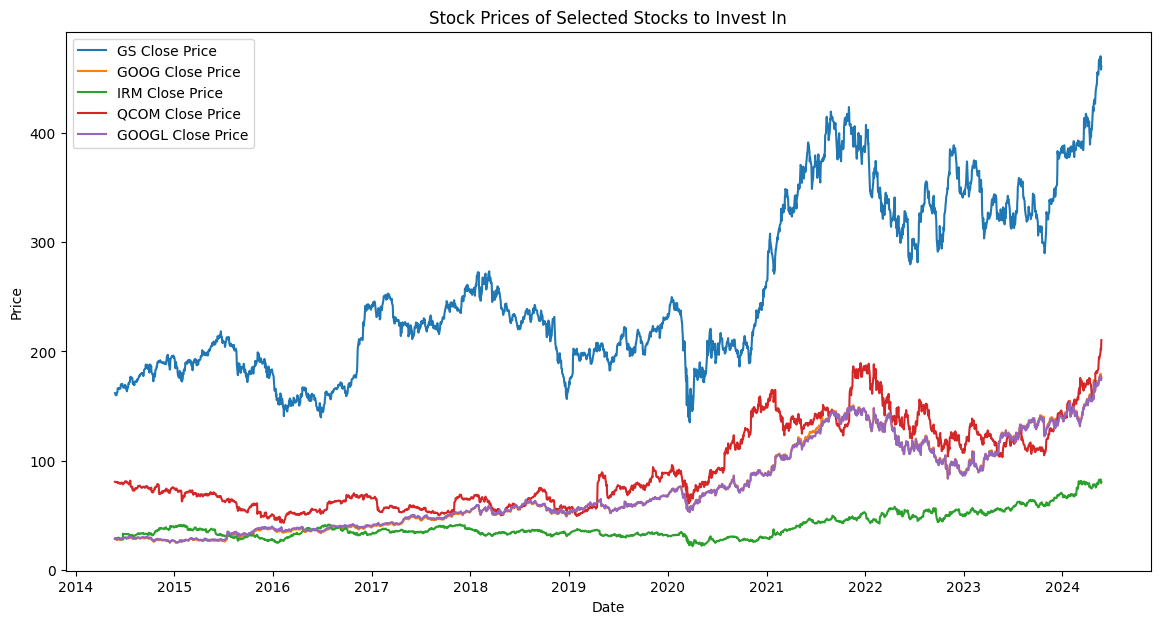

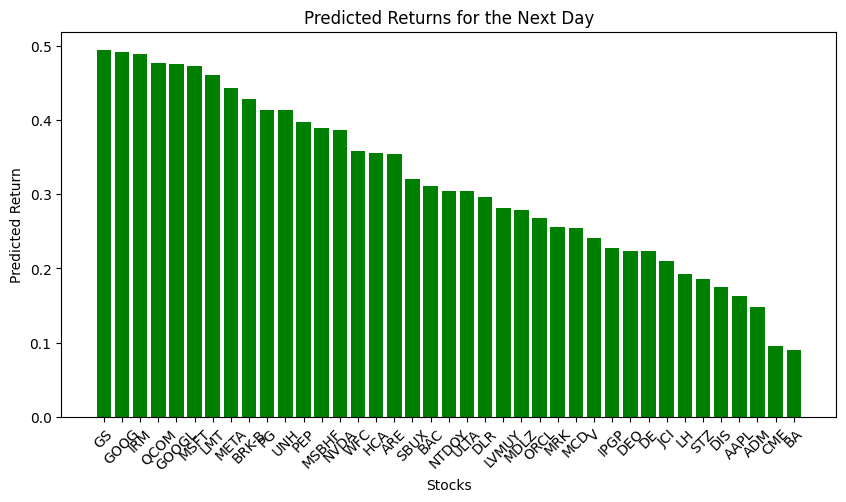

In [18]:
import matplotlib.pyplot as plt

def predict_next_day_return(model, data):
    model.eval()
    last_sequence = data[-seq_length:]
    last_sequence = torch.tensor(last_sequence.values, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(last_sequence)
    return prediction.item()

predicted_returns = {}
for stock, model in models.items():
    predicted_returns[stock] = predict_next_day_return(model, preprocessed_data[stock])

investment_strategy = sorted(predicted_returns.items(), key=lambda x: x[1], reverse=True)
print("Investment Strategy:")
for stock, predicted_return in investment_strategy:
    print(f"Invest in {stock}: Predicted Return = {predicted_return:.4f}")

# Graph the stocks to invest in and their returns
investment_stocks = [stock for stock, _ in investment_strategy[:5]]  # Choose top 5 stocks to invest in

# Plot actual returns of the selected stocks over the last year
plt.figure(figsize=(14, 7))

for stock in investment_stocks:
    data = stock_data[stock]
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    plt.plot(data.index, data['Close'], label=f"{stock} Close Price")

plt.title("Stock Prices of Selected Stocks to Invest In")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plot predicted returns for the next day
plt.figure(figsize=(10, 5))

predicted_returns_sorted = sorted(predicted_returns.items(), key=lambda x: x[1], reverse=True)
stocks = [stock for stock, _ in predicted_returns_sorted]
returns = [predicted_return for _, predicted_return in predicted_returns_sorted]

plt.bar(stocks, returns, color='green')
plt.title("Predicted Returns for the Next Day")
plt.xlabel("Stocks")
plt.ylabel("Predicted Return")
plt.xticks(rotation=45)
plt.show()